In [1]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 53.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
!python -m spacy download sl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 95.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('sl_core_news_sm')


In [4]:
import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import en_core_web_md
import sl_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")


In [5]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
def load_data(src_lang, target_lang):

    dataset_name = f"{src_lang}-{target_lang}"
    ds = datasets.load_dataset("Helsinki-NLP/europarl", dataset_name, split="train[:3%]").shuffle(seed=seed)

    return ds

In [7]:
dataset = load_data('en', 'sl')
dataset

Dataset({
    features: ['translation'],
    num_rows: 18744
})

In [8]:
def remove_translation_key(dataset):
    return dataset['translation']

dataset = dataset.map(remove_translation_key, remove_columns=["translation"])

In [9]:

split_dataset = dataset.train_test_split(test_size=0.1, seed = seed)

train_dataset = split_dataset['train']
valid_dataset = split_dataset['test']

In [10]:

train_dataset[0]

{'en': 'As underlined in your report, finding ways to encourage consumer demand for fuel-efficient cars will enable us significantly to reduce their environmental impact, along with the fuel bill of drivers in the European Union.',
 'sl': 'Kot je izpostavljeno v poročilu, bomo lahko zaradi novih načinov za spodbujanje povpraševanja potrošnikov po varčnih osebnih vozilih znatno zmanjšali njihov vpliv na okolje, skupaj z računom voznikov za gorivo v Evropski uniji.'}

In [11]:

with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_dataset[:5])
    display(example_df)

,en,sl
0,"As underlined in your report, finding ways to encourage consumer demand for fuel-efficient cars will enable us significantly to reduce their environmental impact, along with the fuel bill of drivers in the European Union.","Kot je izpostavljeno v poročilu, bomo lahko zaradi novih načinov za spodbujanje povpraševanja potrošnikov po varčnih osebnih vozilih znatno zmanjšali njihov vpliv na okolje, skupaj z računom voznikov za gorivo v Evropski uniji."
1,"Mr President, I am delighted to see that most of our Group's contribution to the opinion of the Committee on Economic and Monetary Affairs has been incorporated in Mr Toubon's excellent report.","Gospod predsednik, veseli me, da je bila večina prispevka naše skupine k mnenju Odbora o ekonomskih in monetarnih zadevah vključena v odlično poročilo gospoda Toubona."
2,"With this text, the European Union will gain the tools it needs to continue its integration, to expand and to deepen its common policies.","S tem besedilom bo Evropska unija pridobila orodja, ki jih potrebuje za nadaljnje povezovanja, za širitev in poglobitev svoje skupne politike."
3,"Nevertheless, reading the report, I was surprised, as a citizen of a recently acceded country, at the impression that it addresses a Union made up only of countries with developed economies, or rather, with equally developed economies, which is not true.","Vseeno pa sem bil med branjem poročila kot državljan nedavno pridružene države presenečen nad vtisom, da nagovarja Unijo, ki je sestavljena le iz držav z razvitimi gospodarstvi, ali raje, z enako razvitimi gospodarstvi, kar pa ne drži."
4,We expressed great concern over the continued closure of major crossing points.,Izrazili smo veliko zaskrbljenost zaradi stalnega zapiranja glavnih prehodov.


In [12]:

en_nlp = en_core_web_md.load()
sl_nlp = sl_core_news_sm.load()

In [13]:
def tokenize_example(
    example,
    en_nlp,
    sl_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example['en'])][:max_length]
    sl_tokens = [token.text for token in sl_nlp.tokenizer(example['sl'])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        sl_tokens = [token.lower() for token in sl_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    sl_tokens = [sos_token] + sl_tokens + [eos_token]
    return {"en_tokens": en_tokens, "sl_tokens": sl_tokens}

In [14]:
max_length = 200
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "sl_nlp": sl_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_dataset = train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

In [15]:
train_dataset

Dataset({
    features: ['en', 'sl', 'en_tokens', 'sl_tokens'],
    num_rows: 16869
})

In [16]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

sl_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["sl_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [17]:
assert en_vocab[unk_token] == sl_vocab[unk_token]
assert en_vocab[pad_token] == sl_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
4


In [18]:
en_vocab.set_default_index(unk_index)
sl_vocab.set_default_index(unk_index)

In [19]:
def numericalize_example(example, en_vocab, sl_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    sl_ids = sl_vocab.lookup_indices(example["sl_tokens"])
    return {"en_ids": en_ids, "sl_ids": sl_ids}


In [20]:
fn_kwargs = {
    "en_vocab": en_vocab,
    "sl_vocab": sl_vocab
}

train_dataset = train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

In [21]:
train_dataset[21]

{'en': 'It is time that advertisements give consumers more details of the fuel economy and emission performance of the vehicles on sale.',
 'sl': 'Zdaj je pravi čas, da se potrošnikom v oglasnih sporočilih zagotovi več podrobnosti v zvezi z ekonomičnostjo porabe goriva in oddajanjem emisij iz vozil, ki so naprodaj.',
 'en_tokens': ['<sos>',
  'it',
  'is',
  'time',
  'that',
  'advertisements',
  'give',
  'consumers',
  'more',
  'details',
  'of',
  'the',
  'fuel',
  'economy',
  'and',
  'emission',
  'performance',
  'of',
  'the',
  'vehicles',
  'on',
  'sale',
  '.',
  '<eos>'],
 'sl_tokens': ['<sos>',
  'zdaj',
  'je',
  'pravi',
  'čas',
  ',',
  'da',
  'se',
  'potrošnikom',
  'v',
  'oglasnih',
  'sporočilih',
  'zagotovi',
  'več',
  'podrobnosti',
  'v',
  'zvezi',
  'z',
  'ekonomičnostjo',
  'porabe',
  'goriva',
  'in',
  'oddajanjem',
  'emisij',
  'iz',
  'vozil',
  ',',
  'ki',
  'so',
  'naprodaj',
  '.',
  '<eos>'],
 'en_ids': [2,
  20,
  12,
  94,
  11,
  0,
  

In [22]:
data_type = "torch"
format_columns = ["en_ids", "sl_ids"]

train_dataset = train_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

valid_dataset = valid_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [23]:
def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_sl_ids = [example["sl_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_sl_ids = nn.utils.rnn.pad_sequence(batch_sl_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "sl_ids": batch_sl_ids,
        }
        return batch

    return collate_fn

In [24]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [25]:
batch_size = 32

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_dataset, batch_size, pad_index)

In [26]:
batch = next(iter(train_data_loader))
print("EN IDs", batch["en_ids"].max())
print("SL IDs :", batch["sl_ids"].max())

EN IDs tensor(8047)
SL IDs : tensor(14367)


In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(0.32)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

In [28]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim,
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)

        return torch.softmax(attention, dim=1)


In [29]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim,
            output_dim
        )
        self.dropout = nn.Dropout(0.32)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
       
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [30]:
input_dim = len(sl_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working'

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
       
        input = trg[0,:]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [32]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14491, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.32, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(8429, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=8429, bias=True)
    (dropout): Dropout(p=0.32, inplace=False)
  )
)

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14491, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.32, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(8429, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=8429, bias=True)
    (dropout): Dropout(p=0.32, inplace=False)
  )
)

In [34]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [35]:
torch.cuda.empty_cache()

In [36]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["sl_ids"].to(device)
        trg = batch["en_ids"].to(device)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["sl_ids"].to(device)
            trg = batch["en_ids"].to(device)
       
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [37]:
n_epochs = 12
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses = []
val_losses = []
best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):

    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )

    train_losses.append(train_loss)

    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_sl.pt'))

    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")


  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   5.945
	Valid Loss:   5.891


0it [00:00, ?it/s]

	Train Loss:   5.298
	Valid Loss:   5.669


0it [00:00, ?it/s]

	Train Loss:   4.915
	Valid Loss:   5.475


0it [00:00, ?it/s]

	Train Loss:   4.556
	Valid Loss:   5.274


0it [00:00, ?it/s]

	Train Loss:   4.207
	Valid Loss:   5.176


0it [00:00, ?it/s]

	Train Loss:   3.878
	Valid Loss:   5.097


0it [00:00, ?it/s]

	Train Loss:   3.620
	Valid Loss:   5.118


0it [00:00, ?it/s]

	Train Loss:   3.362
	Valid Loss:   5.135


0it [00:00, ?it/s]

	Train Loss:   3.160
	Valid Loss:   5.128


0it [00:00, ?it/s]

	Train Loss:   2.970
	Valid Loss:   5.192


0it [00:00, ?it/s]

	Train Loss:   2.818
	Valid Loss:   5.200


0it [00:00, ?it/s]

	Train Loss:   2.689
	Valid Loss:   5.287


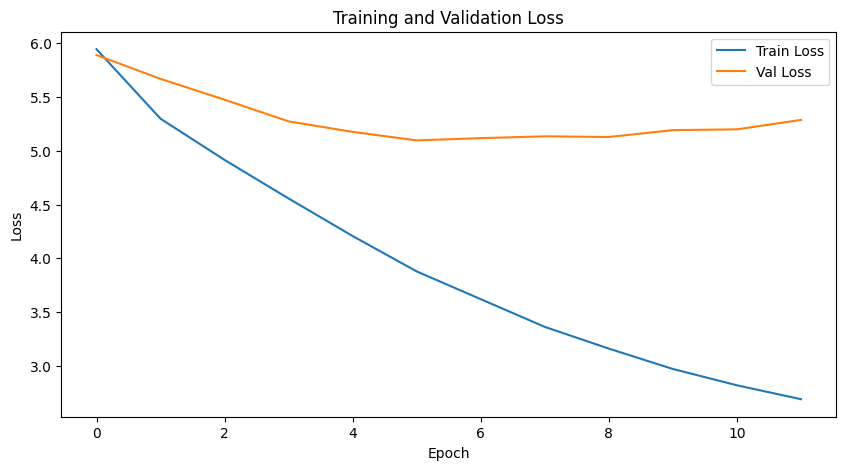

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [39]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[:len(en_tokens)-1]

In [40]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10,10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [41]:
sentence = valid_dataset[0]["sl"]
expected_translation = valid_dataset[0]["en"]

sentence, expected_translation

('Dezertifikacija se na svetovni ravni širi, kar vodi v revščino, prisilno preseljevanje in spore.',
 'At a global level desertification is increasing, leading to poverty, forced migration and conflict.')

In [44]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    sl_nlp,
    en_vocab,
    sl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'desertification', 'is', 'internationally', 'at', 'global', 'global', ',', ',', 'which', 'is', ',', 'poverty', ',', 'conflict', 'and', 'conflict', 'and', 'conflict', '.', '<eos>']
['<sos>', 'dezertifikacija', 'se', 'na', 'svetovni', 'ravni', 'širi', ',', 'kar', 'vodi', 'v', 'revščino', ',', 'prisilno', 'preseljevanje', 'in', 'spore', '.', '<eos>']


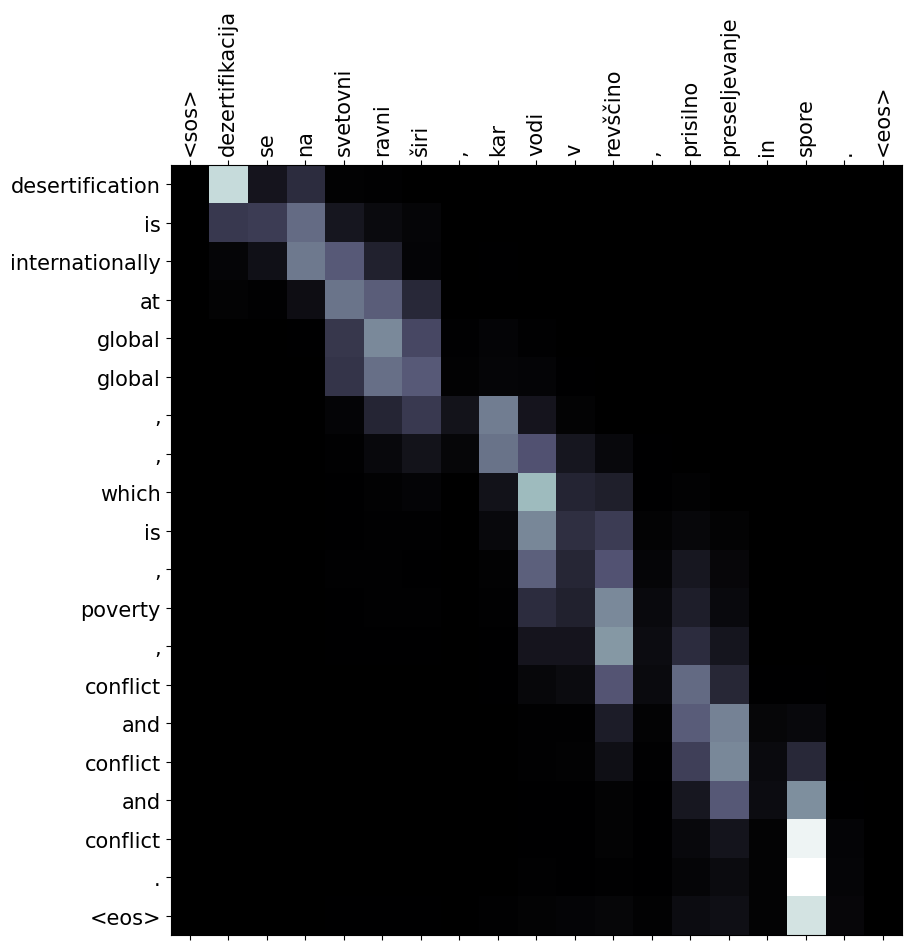

In [45]:
plot_attention(sentence_tokens, translation, attention)

In [46]:
sentence = valid_dataset[45]["sl"]
expected_translation = valid_dataset[45]["en"]

sentence, expected_translation

('Menim, da mora biti naša prednostna naloga, da odgovorimo na ti dve vprašanji, in če bi to storili, bi odkrili, da so bili izredni ukrepi pogosto napačni in da so bili seznami terorističnih organizacij nenatančni ter da so nanje vplivali politični motivi in ne resnična nevarnost teh organizacij.',
 'I believe we should make it a priority to answer these two questions, and that if we did so we would discover that emergency measures have often been mistaken and that the lists of terrorist organisations have been imprecise, often dictated more by political motives than a real danger posed by the organisations.')

In [47]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    sl_nlp,
    en_vocab,
    sl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'i', 'think', 'that', 'priority', 'priority', 'should', 'be', '<unk>', 'on', 'issues', 'issues', 'and', ',', 'if', 'this', ',', 'and', ',', 'that', ',', 'that', 'the', 'measures', 'that', 'have']
['<sos>', 'menim', ',', 'da', 'mora', 'biti', 'naša', 'prednostna', 'naloga', ',', 'da', 'odgovorimo', 'na', 'ti', 'dve', 'vprašanji', ',', 'in', 'če', 'bi', 'to', 'storili', ',', 'bi', 'odkrili', ',', 'da', 'so', 'bili', 'izredni', 'ukrepi', 'pogosto', 'napačni', 'in', 'da', 'so', 'bili', 'seznami', 'terorističnih', 'organizacij', 'nenatančni', 'ter', 'da', 'so', 'nanje', 'vplivali', 'politični', 'motivi', 'in', 'ne', 'resnična', 'nevarnost', 'teh', 'organizacij', '.', '<eos>']


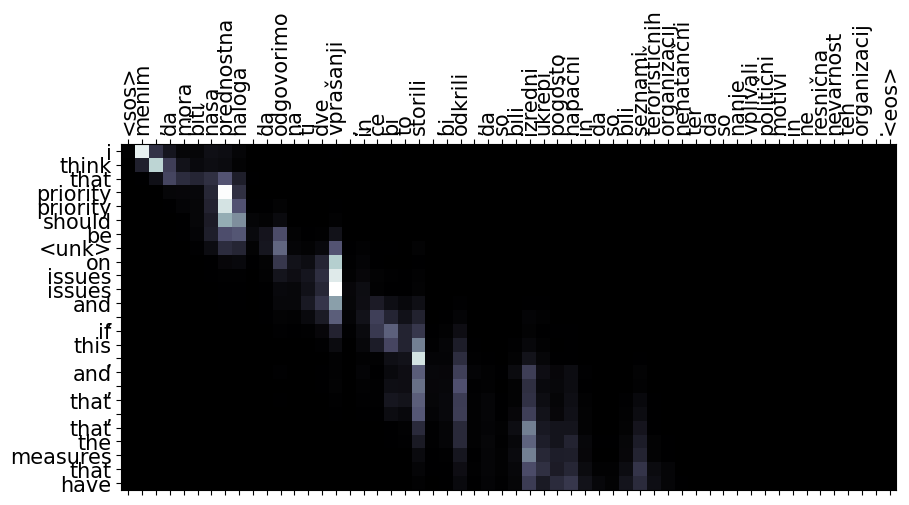

In [48]:
plot_attention(sentence_tokens, translation, attention)

In [50]:
sentence = valid_dataset[101]["sl"]
expected_translation = valid_dataset[101]["en"]

sentence, expected_translation

('Zelo pomemben predlog je večje sodelovanje nacionalnih parlamentov, da bi se boljše izrazila različna stališča držav članic in njenih državljanov.',
 'More involvement of national parliaments to better reflect the diverse views of Member States and their citizens is a very important proposal.')

In [52]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    sl_nlp,
    en_vocab,
    sl_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'a', 'very', 'important', 'proposal', 'for', 'involvement', 'involvement', 'of', 'national', 'parliaments', ',', 'to', 'the', 'the', 'of', 'the', 'member', 'states', 'and', 'its', 'its', 'its', 'its', 'its', 'citizens']
['<sos>', 'zelo', 'pomemben', 'predlog', 'je', 'večje', 'sodelovanje', 'nacionalnih', 'parlamentov', ',', 'da', 'bi', 'se', 'boljše', 'izrazila', 'različna', 'stališča', 'držav', 'članic', 'in', 'njenih', 'državljanov', '.', '<eos>']


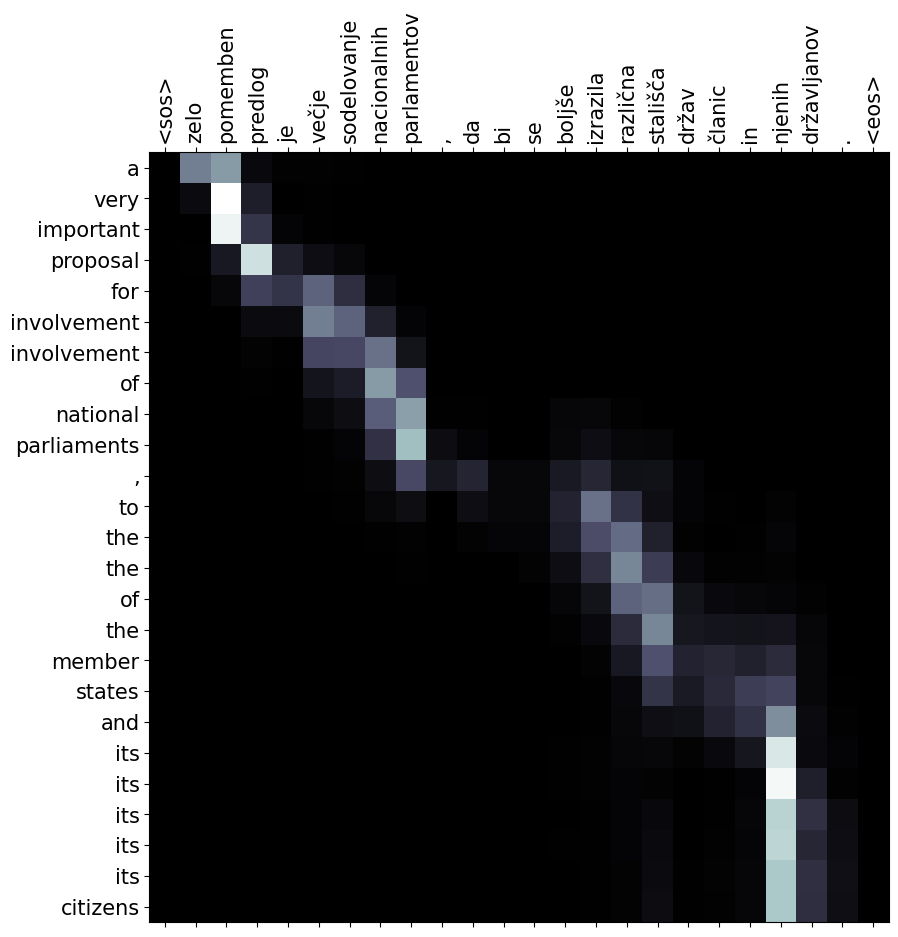

In [53]:
plot_attention(sentence_tokens, translation, attention)